In [1]:
# imports
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import matplotlib.pyplot as plt

## Model 1 - Logistic Regression

In [2]:
df = pd.read_csv('./Data/subreddit_data_post_eda.csv')

In [3]:
df.head()

,title,selftext,subreddit,title_length,title_word_count,title_selftext,title_selftext_length,title_selftext_word_count,sentiment_compound,sentiment_negative,sentiment_neutral,sentiment_positive
0,"I was suggested to post this puzzle here ,hope...",NaN,0,65,14,"I was suggested to post this puzzle here ,hope...",65,14,0.8126,0.000,0.543,0.457
1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7,Programs for analyzing and annotating my games...,46,7,0.0000,0.000,1.000,0.000
2,Who is GM Watneg on lichess?,NaN,0,28,6,Who is GM Watneg on lichess?,28,6,0.0000,0.000,1.000,0.000
3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4,Glitch in Lichess Analysis&amp;#x200B;\n\n[I w...,26,4,0.0000,0.000,1.000,0.000
4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34,Does anyone know what the heck a zero day that...,162,34,-0.5043,0.121,0.879,0.000


In [46]:
df.dtypes

title                         object
selftext                      object
subreddit                      int64
title_length                   int64
title_word_count               int64
title_selftext                object
title_selftext_length          int64
title_selftext_word_count      int64
sentiment_compound           float64
sentiment_negative           float64
sentiment_neutral            float64
sentiment_positive           float64
dtype: object

### Baseline Model

In [4]:
# Baseline Model.  We need to beat 50%.
df['subreddit'].value_counts(normalize = True)

1    0.500375
0    0.499625
Name: subreddit, dtype: float64

In [5]:
# Create X and Y 
X = df.drop(columns = ['subreddit'])
y = df['subreddit']

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [7]:
# create two functions for FeatureUnion
def get_title(df):
    return df['title_selftext']

get_title_transformer = FunctionTransformer(get_title, validate = False)

def other_columns(df):
    return df[['title_selftext_length', 'sentiment_compound', 'title_selftext_word_count']]

get_columns_transformer = FunctionTransformer(other_columns, validate = False)

In [8]:
# Set up two pipelines.  

pipe_cv = Pipeline([
    ('title_transform', get_title_transformer),
    ('vect', CountVectorizer())
])

# FeatureUnion in the second pipeline will combine the CountVectorized columns and the other features
outer_pipe = Pipeline([
    ('feats', FeatureUnion([
        ('vect_pipe', pipe_cv),
        ('other_cols', get_columns_transformer)
    ])),
    ('model', LogisticRegression())
])

In [9]:
# GridSearch for best hyperparemeters
param_grid = {
    'model__max_iter': [1000],
    'feats__vect_pipe__vect__max_features': [None, 4000, 5000],
    'feats__vect_pipe__vect__min_df' : [2,3],
    'feats__vect_pipe__vect__max_df' : [.90],
    'feats__vect_pipe__vect__stop_words' : ['english', ['game', 'games', 'player', 'players']]
    }
gs = GridSearchCV(outer_pipe, param_grid=param_grid)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9596227045075125


{'feats__vect_pipe__vect__max_df': 0.9,
 'feats__vect_pipe__vect__max_features': None,
 'feats__vect_pipe__vect__min_df': 2,
 'feats__vect_pipe__vect__stop_words': 'english',
 'model__max_iter': 1000}

95.9% Accuracy!

### Model Evaluation

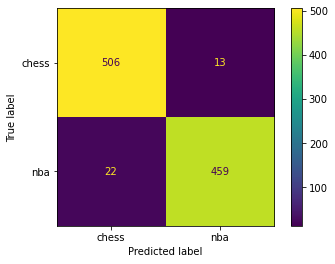

In [10]:
plot_confusion_matrix(gs, X_test, y_test, display_labels = ['chess', 'nba']);

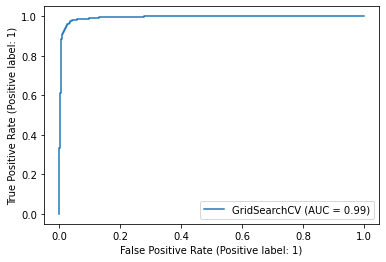

In [11]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(gs, X_test, y_test);

### What are some of the words that did the best job in predicting class?

In [12]:
# Investigate coefficients (remember bc of logreg, we'll ultimately have to np.exp them)
gs.best_estimator_.named_steps['model'].coef_
# got the coefficients, now need the feature names before zipping them together.

array([[-0.20741066, -0.1333673 ,  0.07148026, ...,  0.03732919,
        -0.16441825, -0.15840206]])

In [13]:
a = gs.best_estimator_.named_steps['model'].coef_ # get coefficients
b = gs.best_estimator_.named_steps['feats'].transformer_list[0][1].named_steps['vect'].get_feature_names() #get feature names
coefs_and_names = zip(a[0], b) #zip them together
lst = list(coefs_and_names) #turn zip object into a list
holygrail = pd.DataFrame(lst) # turn list into a df
holygrail[0] = np.exp(holygrail[0]) # because logistic regression puts the coefficients on a log scale, you have to do this.

In [14]:
holygrail.head()

,0,1
0,0.812686,00
1,0.875144,000
2,1.074097,00s
3,0.970161,01
4,1.031554,02


In [15]:
holygrail.sort_values(by = 0)

,0,1
1288,0.029661,chess
6287,0.168288,white
949,0.199430,black
3613,0.206758,magnus
2871,0.210583,hikaru
...,...,...
5487,6.110826,star
3440,7.319260,lebron
2867,9.521037,highlight
4842,10.552410,removed


For each instance of "lebron", its 11.7 times more likely to be the nba subreddit than the chess subreddit.

In [16]:
holygrail.sort_values(by=0, ascending=False).head(10)

,0,1
3925,14.501403,nba
4842,10.552410,removed
2867,9.521037,highlight
3440,7.319260,lebron
5487,6.110826,star
845,4.303691,basketball
5528,4.225779,steph
6413,3.997741,zion
2791,3.705182,harden
5752,3.459195,team


In [17]:
top_ten = holygrail.sort_values(by=0, ascending=False).tail(10)
top_ten

,0,1
3253,0.283251,karjakin
1281,0.261453,checkmate
3682,0.244724,mate
599,0.237724,anish
3477,0.236192,lichess
2871,0.210583,hikaru
3613,0.206758,magnus
949,0.199430,black
6287,0.168288,white
1288,0.029661,chess


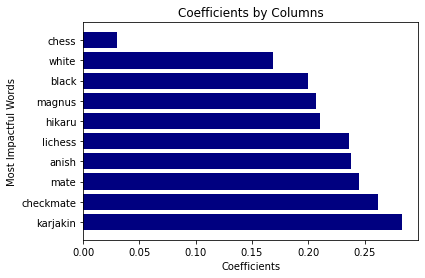

<Figure size 576x432 with 0 Axes>

In [18]:
plt.barh(top_ten[1], top_ten[0], color='navy')
plt.title('Coefficients by Columns')
plt.ylabel('Most Impactful Words')
plt.xlabel('Coefficients')
plt.savefig("./graphics/Best Predictors Chess.jpg", bbox_inches="tight", dpi=100)
plt.figure(figsize=(8,6))
plt.tight_layout(); 

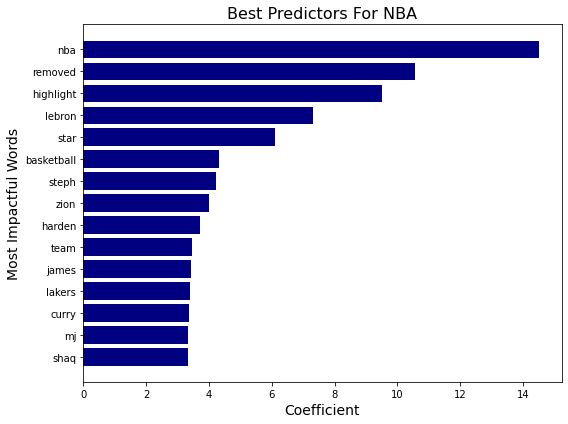

In [19]:
plt.figure(figsize=(8,6))
best_pred_sust = holygrail.sort_values(by=0, ascending=True).tail(15)
x = best_pred_sust[1]
y = best_pred_sust[0]
plt.barh(x,y, color ='navy')
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.ylabel('Most Impactful Words', fontdict= {'fontsize':14})
plt.title('Best Predictors For NBA', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig("./graphics/Best Predictors NBA.jpg", bbox_inches="tight", dpi=100);

### Predictions

In [20]:
preds = gs.predict(X_test)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       519
           1       0.97      0.95      0.96       481

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.96      0.96      1000



In [22]:
#all the documents where the model predicted incorrectly (Type I and Type II errors)
all_errors = X_test[y_test != preds]
# add back the class column, df['subreddit']
all_errors = pd.merge(all_errors, df['subreddit'], left_index=True, right_index=True)

all_errors.head()

,title,selftext,title_length,title_word_count,title_selftext,title_selftext_length,title_selftext_word_count,sentiment_compound,sentiment_negative,sentiment_neutral,sentiment_positive,subreddit
3891,Ernie Johnson Rap put to a beat,NaN,31,7,Ernie Johnson Rap put to a beat,31,7,0.0000,0.000,1.000,0.000,1
3984,well I guess that's that then...,NaN,32,6,well I guess that's that then...,32,6,0.2732,0.000,0.656,0.344,1
3282,JJ Redick goes crazy in the new State Farm com...,NaN,55,11,JJ Redick goes crazy in the new State Farm com...,55,11,0.0857,0.183,0.609,0.208,1
3128,LEAKS: 40 2022-23 uniform designs have been re...,NaN,234,38,LEAKS: 40 2022-23 uniform designs have been re...,234,38,0.4404,0.000,0.927,0.073,1
2333,Mama where is that man,Whats the update on markieff morris? Is he jus...,22,5,Mama where is that manWhats the update on mark...,22,5,0.0000,0.000,1.000,0.000,1


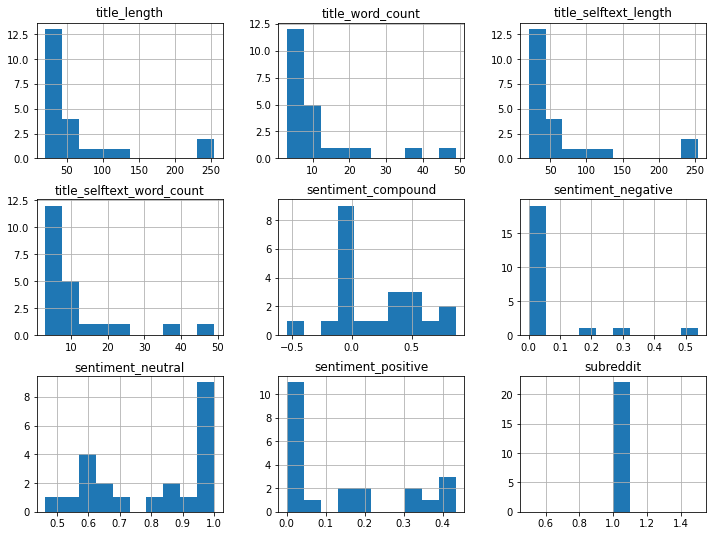

In [23]:
chess_misclassified = all_errors[all_errors['subreddit'] == 1]
chess_misclassified.hist(figsize=(12,9));
# distributions for records that were predicted to be chess, but they were nba.

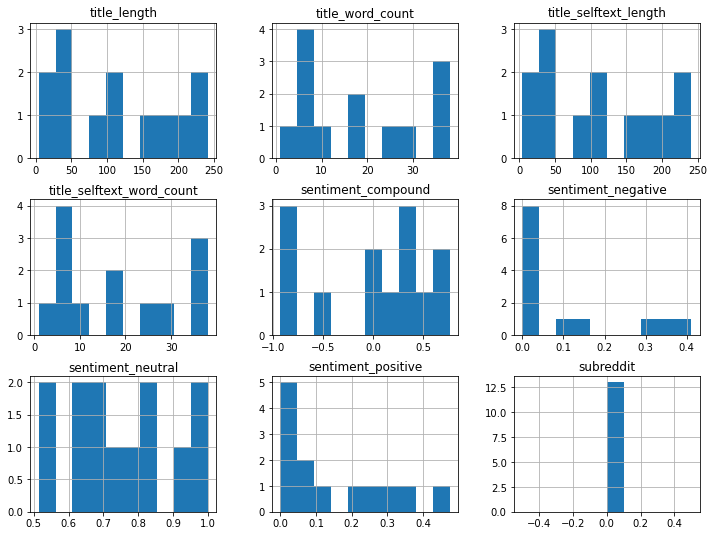

In [24]:
nba_misclassified = all_errors[all_errors['subreddit'] == 0]
nba_misclassified.hist(figsize=(12,9));
# distributions for records that were predicted to be nba, but they were chess.

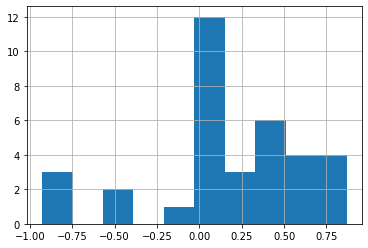

In [25]:
all_errors['sentiment_compound'].hist();
#the model's mistakes seem to be primarily with posts that had a positive sentiment score

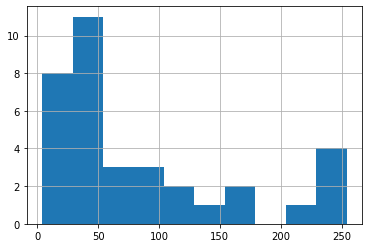

In [26]:
all_errors['title_length'].hist();
#if you compare this to the same histogram from the original df, the title lengths here are much shorter.  
#the peak of the original distribution (in EDA notebook) was a title length of 50.  Here, it's a title length of ~35.
#so a lot of the model's mistakes 

## Model 2 - Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
df = pd.read_csv('./Data/subreddit_data_post_eda.csv')
df.head()

,title,selftext,subreddit,title_length,title_word_count,title_selftext,title_selftext_length,title_selftext_word_count,sentiment_compound,sentiment_negative,sentiment_neutral,sentiment_positive
0,"I was suggested to post this puzzle here ,hope...",NaN,0,65,14,"I was suggested to post this puzzle here ,hope...",65,14,0.8126,0.000,0.543,0.457
1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7,Programs for analyzing and annotating my games...,46,7,0.0000,0.000,1.000,0.000
2,Who is GM Watneg on lichess?,NaN,0,28,6,Who is GM Watneg on lichess?,28,6,0.0000,0.000,1.000,0.000
3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4,Glitch in Lichess Analysis&amp;#x200B;\n\n[I w...,26,4,0.0000,0.000,1.000,0.000
4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34,Does anyone know what the heck a zero day that...,162,34,-0.5043,0.121,0.879,0.000


In [29]:
# Baseline Model.  We need to beat 50%.
df['subreddit'].value_counts(normalize = True)

1    0.500375
0    0.499625
Name: subreddit, dtype: float64

In [30]:
# Create X and Y for CountVectorizer

X = df['title_selftext']
y = df['subreddit']

In [31]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [32]:
# Create Pipeline
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', RandomForestClassifier())
])

In [33]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.963

In [34]:
param_grid = {
    'vect__stop_words': ['english', None],
    'vect__max_features': [None, 4000, 5000],
    'vect__min_df' : [2,3]
    # 'vect__max_df' : [.95],
    # 'vect__ngram_range' : [(1,1),(1,2)]
}
gs = GridSearchCV(pipe, param_grid=param_grid)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9552849193099611


{'vect__max_features': 4000, 'vect__min_df': 3, 'vect__stop_words': 'english'}

### Model Evaluation

95.5% accuracy.  Not quite as good as the Logistic Regression model.

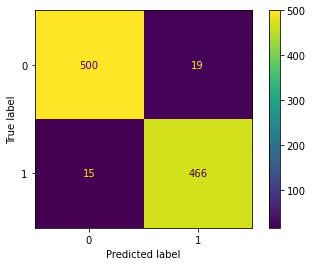

In [35]:
plot_confusion_matrix(gs, X_test, y_test);

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       519
           1       0.97      0.95      0.96       481

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.96      0.96      1000



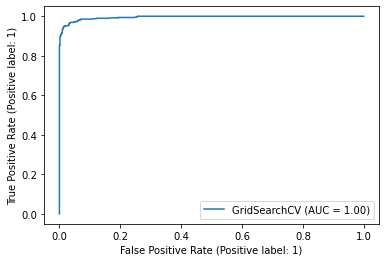

In [38]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(gs, X_test, y_test);

In [39]:
a = gs.best_estimator_._final_estimator.feature_importances_ #get coefficients
b = gs.best_estimator_['vect'].get_feature_names() #get feature names
zip_object = zip(a,b) # zip coefficients and feature names together
lst = list(zip_object) # save to list
holygrail = pd.DataFrame(lst) # convert that list to data frame

In [41]:
holygrail.sort_values(by=0, ascending=True).tail(10)

,0,1
2066,0.011190,lakers
615,0.016955,black
3905,0.017544,white
1778,0.018547,highlight
3561,0.018911,team
3405,0.021816,star
2103,0.022042,lebron
3036,0.037603,removed
2444,0.056016,nba
859,0.098242,chess
